Notebook purpose:

- Validate balances

Approach:

1. Identify od fee txns
2. For each user-month, create dummies indicating whether was in overdraft and paid od fees
3. Explore relationship between above dummies

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('/Users/fgu/dev/projects/entropy')
import entropy.helpers.aws as aws
import entropy.data.cleaners as cl
import entropy.data.creators as cr

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
def tag_od_txns(df):
    """Tags overdraft fee payments."""
    pattern = r'\b(?:od|o d|overdraft|o draft)\b.*(?:fee|usage|interest)'
    is_od_fee_txn = df.desc.str.contains(pattern) & df.debit
    df['od_fee_txn'] = is_od_fee_txn
    return df

SAMPLE = 'X77'
fp = f'~/tmp/entropy_{SAMPLE}.parquet'


df = aws.read_parquet(fp)
df = tag_od_txns(df)

print('Rows: {:,.0f}\nUsers: {}'.format(df.shape[0], df.user_id.nunique()))
df.head(1)

Rows: 646,650
Users: 215


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,desc_old,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,savings,od_fee_txn
0,688261,2012-01-03,777,400.0,mdbremoved,NaN,transfers,transfers,False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-11-13,True,<mdbremoved> - s/o,364.220001,non merchant mbl,transfers,other account,other account,u,201201,-1542.99646,24319.220881,False,False


## Identify overdraft fee txns

Approach: inspect txn descriptions for relevant tags and note down od-related ones, then inspect common tags for these od-descriptions, then check for additional od-related txns in these tags. Based on that, design regex pattern and gauge precision and recall. 

Hypothesised pattern based on data inspection (omits word boundary for second group as there are txns descriptions where *interest* is part of a larger words like *interestto*).

In [3]:
pattern = r'\b(?:od|o d|overdraft|o draft)\b.*(?:fee|usage|interest)'
mask = df.desc.str.contains(pattern) & df.debit

Matches only txns with relevant tags

In [4]:
od_fees = df[mask]
tag_counts = od_fees.tag_auto.value_counts()
tag_counts[:5]

bank charges        9397
interest charges     173
interest income      137
banking charges       95
accessories            0
Name: tag_auto, dtype: int64

Has high precision (i.e. very few -- no? -- false positives)

In [5]:
od_fees.desc.sample(n=10)

488400    daily od fee 08 06
624811    daily od fee 01 03
242287      daily od fee chg
537753          daily od fee
539070          daily od fee
384784      daily od fee chg
384945      daily od fee chg
636756          daily od fee
623870          daily od fee
537642          daily od fee
Name: desc, dtype: object

Seems to have high recall (i.e. finds most od-related txns). Below shows that using a less restrictive pattern has no more true positives but a few false positives (being yet less restrictive and omitting word boundary around first group finds thousandas of irrelevant txns, like `desc`s containing *food*, and finds only a handful of addition bank charges txns).

In [6]:
pattern_alt = r'\b(?:od|o d|overdraft|o draft)\b'
mask_alt = df.desc.str.contains(pattern_alt) & df.debit
df[mask_alt].tag_auto.value_counts()[:9]

bank charges                9654
interest charges             173
interest income              137
banking charges               95
enjoyment                      2
cash                           1
tv / movies package            1
entertainment, tv, media       1
paypal account                 0
Name: tag_auto, dtype: int64

In [7]:
mask_alt = df.desc.str.contains(pattern_alt) & df.debit & df.tag_auto.str.contains('enjoyment|cash|tv')
df[mask_alt].desc

117905                                                    paypal c o d e x cd 7038 deb
426340                       visa cash withdrawal trg od oruzja eur 30 00000 at 1 1274
442285                                    amzn mktp uk od 0us luxembourg on 12 jan bcc
485168    card payment to kindle svcs od 3553gv 5 3 99 gbp rate 1 00 gbp on 20 01 2020
525398                               3395 24jan 20 prime video od 8k67ny 5 353 7661 lu
Name: desc, dtype: object

## Create dummies for in overdraft and paid od fee

For each user-month, create a dummies indicating whether the user's current account was in overdraft and whether they paid overdraft fees.

In [8]:
def make_overdraft_data(df):
    mask = (df.account_type.eq('current'),
            ['user_id', 'date', 'balance', 'od_fee_txn'])        
    month = pd.Grouper(key='date', freq='M')    
    od_fee_paid = lambda s: s.max() == 1
    in_od = lambda s: s.min() < 0
    
    return (df.loc[mask]
            .groupby(['user_id', month])
            .agg(od_fee_paid=('od_fee_txn', od_fee_paid),
                 in_od=('balance', in_od))
            .groupby('user_id')
            .resample('M', level='date').first()
            .fillna(0).astype(bool))

od = make_overdraft_data(df)
od.head()

od_fee_paid  in_od
user_id date                          
777     2012-01-31        False   True
        2012-02-29        False   True
        2012-03-31        False  False
        2012-04-30        False   True
        2012-05-31        False   True

## Explore relationship between being in od and paying od fees

### Relationship between od fees paid this month and in od this month

In [9]:
def fee_od_matrix(od_data, in_od_col='in_od'):
    """Print confusion matrix for od_fee_paid and in_od columns."""
    m = (od_data.groupby(['od_fee_paid', in_od_col]).size()
         .reset_index()
         .pivot(in_od_col, 'od_fee_paid')
         .droplevel(level=0, axis=1))
    
    correct = np.diag(m).sum()
    share_correct = correct / m.sum().sum()
    print(f'Total (and share) correct: {correct} ({share_correct:.1%})')
    return m

fee_od_matrix(od)

Total (and share) correct: 3757 (57.7%)


od_fee_paid,False,True
in_od,,
False,2506,116
True,2638,1251


### Relationship between od fees paid this month and od this or previous month

In [10]:
od['in_od2'] = np.maximum(od.in_od, od.in_od.shift()) == 1
od[18:21]

od_fee_paid  in_od  in_od2
user_id date                                  
777     2013-07-31        False   True    True
        2013-08-31        False  False    True
        2013-09-30        False  False   False

In [11]:
fee_od_matrix(od, in_od_col='in_od2')

Total (and share) correct: 3448 (53.0%)


od_fee_paid,False,True
in_od2,,
False,2152,71
True,2992,1296


## balances

there should be no current and savings accounts with nan balance. what to do with other accounts in analysis?

In [12]:
d = df[df.user_id == 777]

g = d.groupby('account_id')

def helper(g):
    last_refresh_balance = g.latest_balance.iloc[0]
    last_refresh_date = g.account_last_refreshed.iloc[0]

    daily_net_spend = g.set_index('date').resample('D').amount.sum()
    cum_balance = daily_net_spend.cumsum().mul(-1)

    # get cum_balance on last refreshed date or nearest preceeding date 
    idx = cum_balance.index.get_loc(last_refresh_date, method='ffill')
    last_refresh_cum_balance = cum_balance[idx]

    starting_balance = last_refresh_balance - last_refresh_cum_balance
    balance = cum_balance + starting_balance
#     return balance.rename('balance')
    return last_refresh_balance


g.apply(helper)


account_id
262912       43.450001
262913    -1413.829956
262914     1637.530029
262915       28.090000
262916      364.220001
262918     2148.820068
262919             NaN
262920     -305.410004
713688       -9.620000
819747      164.690002
1419375   -1779.660034
1419376    1729.390015
dtype: float32

In [152]:
mask = df.account_type.isin(['current', 'savings']) & df.latest_balance.isna()
df[mask].user_id.nunique() / df.user_id.nunique()

0.5011600928074246

In [140]:
def some_latest_balances_missing(g):
    return g.latest_balance
    
df.groupby('user_id').filter(helper)


account_id
8947               NaN
8948               NaN
8949               NaN
8950               NaN
13872              NaN
              ...     
1724817            NaN
1731987   -6909.620117
1731988            NaN
1731991   -3213.429932
1732510   -6251.020020
Name: latest_balance, Length: 1820, dtype: float32

### Case studies

Look into missing balances data
- All balances missing is okay
- But there shouldn't be missing balances if there are any nonmissing ones

In [134]:
df[df.account_id == 262919]

,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,desc_old,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,savings,od_fee_txn
1205,17851721,2014-04-01,777,54.990002,mcafee 3911 54 99 pound sterling ireland,mcafee,spend,retail,False,wa1 4,2011-07-20,20k to 30k,1969.0,2014-04-24,262919,2019-09-10 11:39:00,barclaycard,credit card,2014-07-18,2017-12-04,True,"mcafee, xxxxxxxx3911 54.99 pound sterling ireland",NaN,mcafee,software,NaN,software,u,201404,NaN,26204.169922,False,False
1258,17851722,2014-04-17,777,1299.969971,cross street garage manchester,NaN,None,None,False,wa1 4,2011-07-20,20k to 30k,1969.0,2014-04-24,262919,2019-09-10 11:39:00,barclaycard,credit card,2014-07-18,2017-10-23,True,"cross street garage, manchester",NaN,NaN,NaN,service / parts / repairs,service / parts / repairs,u,201404,NaN,26204.169922,False,False
1289,17978273,2014-04-25,777,10.700000,mdbremoved payment protecti,NaN,spend,finance,False,wa1 4,2011-07-20,20k to 30k,1969.0,2014-04-24,262919,2019-09-10 11:39:00,barclaycard,credit card,2014-07-18,2018-10-08,True,<mdbremoved> payment protecti,NaN,NaN,payment protection insurance,NaN,payment protection insurance,u,201404,NaN,26204.169922,False,False
1313,19069594,2014-05-06,777,-200.000000,payment thank you,barclaycard,transfers,transfers,False,wa1 4,2011-07-20,20k to 30k,1969.0,2014-04-24,262919,2019-09-10 11:39:00,barclaycard,credit card,2014-07-18,2017-08-13,False,"payment, thank you",NaN,barclaycard,credit card,current account,current account,u,201405,NaN,26204.169922,False,False
1333,19636103,2014-05-10,777,149.940002,currys warrington,dixons,spend,retail,False,wa1 4,2011-07-20,20k to 30k,1969.0,2014-04-24,262919,2019-09-10 11:39:00,barclaycard,credit card,2014-07-18,2017-11-13,True,"currys, warrington",NaN,dixons,personal electronics,NaN,home electronics,u,201405,NaN,26204.169922,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6226,548083999,2019-03-28,777,1.990000,amzn mktp uk mz 4vj 6li 4 6620 1 99 pound sterling luxembourg,amazon,spend,services,False,wa1 4,2011-07-20,20k to 30k,1969.0,2014-04-24,262919,2019-09-10 11:39:00,barclaycard,credit card,2019-05-10,1900-01-01,True,"amzn mktp uk*mz4vj6li4, xxx-xxx-6620 1.99 pound sterling luxembourg",NaN,amazon,enjoyment,NaN,enjoyment,c,201903,NaN,23775.339844,False,False
6227,548084000,2019-03-28,777,2.980000,amzn mktp uk mz 8qq 34g4 am amazon co uk 2 98 pound sterling luxembourg,amazon,spend,services,False,wa1 4,2011-07-20,20k to 30k,1969.0,2014-04-24,262919,2019-09-10 11:39:00,barclaycard,credit card,2019-05-10,1900-01-01,True,"amzn mktp uk*mz8qq34g4 am, amazon.co.uk 2.98 pound sterling luxembourg",NaN,amazon,enjoyment,NaN,enjoyment,c,201903,NaN,23775.339844,False,False
6316,548083998,2019-04-28,777,-4.970000,payment thank you,barclaycard,transfers,transfers,False,wa1 4,2011-07-20,20k to 30k,1969.0,2014-04-24,262919,2019-09-10 11:39:00,barclaycard,credit card,2019-05-10,1900-01-01,False,"payment, thank you",NaN,barclaycard,credit card,credit card payment,credit card payment,c,201904,NaN,23775.339844,False,False
6373,550838914,2019-05-12,777,45.849998,iceland 1509 warrington 45 85 pound sterling great britain,iceland,spend,household,False,wa1 4,2011-07-20,20k to 30k,1969.0,2014-04-24,262919,2019-09-10 11:39:00,barclaycard,credit card,2019-05-16,1900-01-01,True,"iceland 1509, warrington 45.85 pound sterling great britain",NaN,iceland,"food, groceries, household",NaN,"food, groceries, household",c,201905,NaN,23775.339844,False,False


account_id
262919    AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

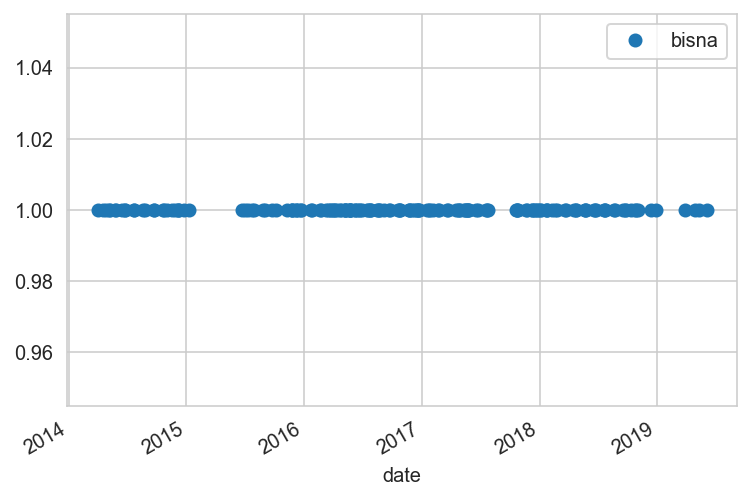

In [155]:
accounts = df[df.balance.isna()].account_id.unique()
dd = df[df.account_id.isin(accounts)].copy()
dd['bisna'] = dd.balance.isna().astype(int)
dd = dd.groupby(['user_id', 'account_id', 'date']).bisna.first().reset_index(level=[0, 1])
dd[dd.user_id == 777].groupby('account_id').plot(y='bisna', marker='o', linewidth=0)

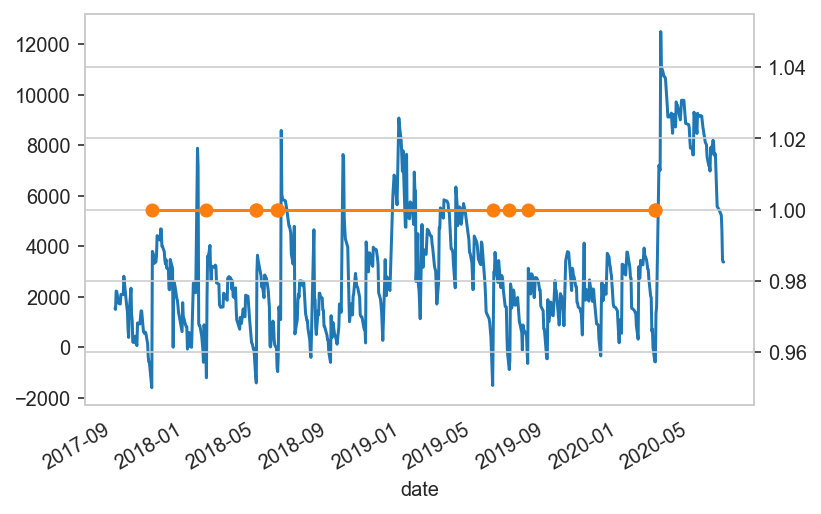

In [54]:
def draw_od_fee_user_sample(df, n=1, seed=2312):
    rng = np.random.default_rng(seed=seed)
    users = df[df.od_fee_txn].user_id.unique()
    return rng.choice(users, size=n)

def make_user_balance_od_fee_data(df, user_id):
    df = df.copy()
    data = df[df.user_id == user_id]
    data = (data.groupby('date')
            .agg({'balance': 'first', 'od_fee_txn': 'max'}))  
    return data

def draw_balance_od_fee_plot(df):
    df.balance.plot()    
    d = df[df.od_fee_txn]
    d.od_fee_txn.astype(int).plot(marker='o', secondary_y=True)    

for user in draw_user_sample(df, n=1, seed=None):
    data = make_user_balance_od_fee_data(df, user)
    draw_balance_od_fee_plot(data)


### Distribution of lag between end/beginning of od and next od fee